In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,auc


In [3]:

def plot_decision_boundary(model,X_data,y_data):
    fig,ax = plt.subplots()
    # Make grid: min to max of 1st column, min to max of 2nd column in small increments
    X1,X2 = np.meshgrid(np.arange(X_data[:, 0].min() - 1, X_data[:, 0].max() + 1, step = 0.01),
                     np.arange(X_data[:, 1].min() - 1, X_data[:, 1].max() + 1, step = 0.01))
    # Flatten X1 and X2, create an array and transpose to a 2-column array (one for each feature)
    v = np.array([X1.ravel(), X2.ravel()]).T
    #  Using fitted model, predict the points in v and reshape to a 2-dimensional array
    ax.contourf(X1, X2, model.predict(v).reshape(X1.shape),alpha = 0.75,cmap = ListedColormap(('magenta','cyan')))
    ax.set_xlim(X1.min(), X1.max())
    ax.set_ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_data)): # For each class
        ax.scatter(X_data[y_data == j, 0], X_data[y_data == j, 1],
                c = np.array(ListedColormap(('white', 'black'))(i)).reshape(1,-1), 
                                            label = j)
    ax.set_title('Test Data');

## Homework2

The homework has three parts.

#### Part 1: (80 pts).
Data Analysis of a dataset with  three different  Classification algorithms.  

Exploratory Data Analysis and Data Preprocessing (20 pts)  
Generic Classification Model and Results (20 pts)  
KNN Model (15 pts)  
Logistic Regression Model (10 pts)  
Support Vector Machine Model (15 pts)  

#### Part 2: (10 pts)
A PyTorch model of the dataset.
#### Part 3: (10 pts)
Two Linear Algebra questions

### Data

#### Goal

Clasify the features into no/yes classes.

In [4]:
df = pd.read_csv("HW2.csv")
df.tail()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,Class
763,10,101.0,76,48,180,32.9,0.171,63,no
764,2,122.0,70,27,0,36.8,0.340,27,no
765,5,NaN,72,23,112,26.2,0.245,30,no
766,1,126.0,60,0,0,30.1,0.349,47,yes
767,1,93.0,70,31,0,30.4,0.315,23,no


### Part 1  Exploratory Data Analysis & Data Preprocessing

Provide descriptive statistics and visualizations of the dataset.

In [5]:
cols = df.columns
preds = cols[0:-1]
target = cols[-1]

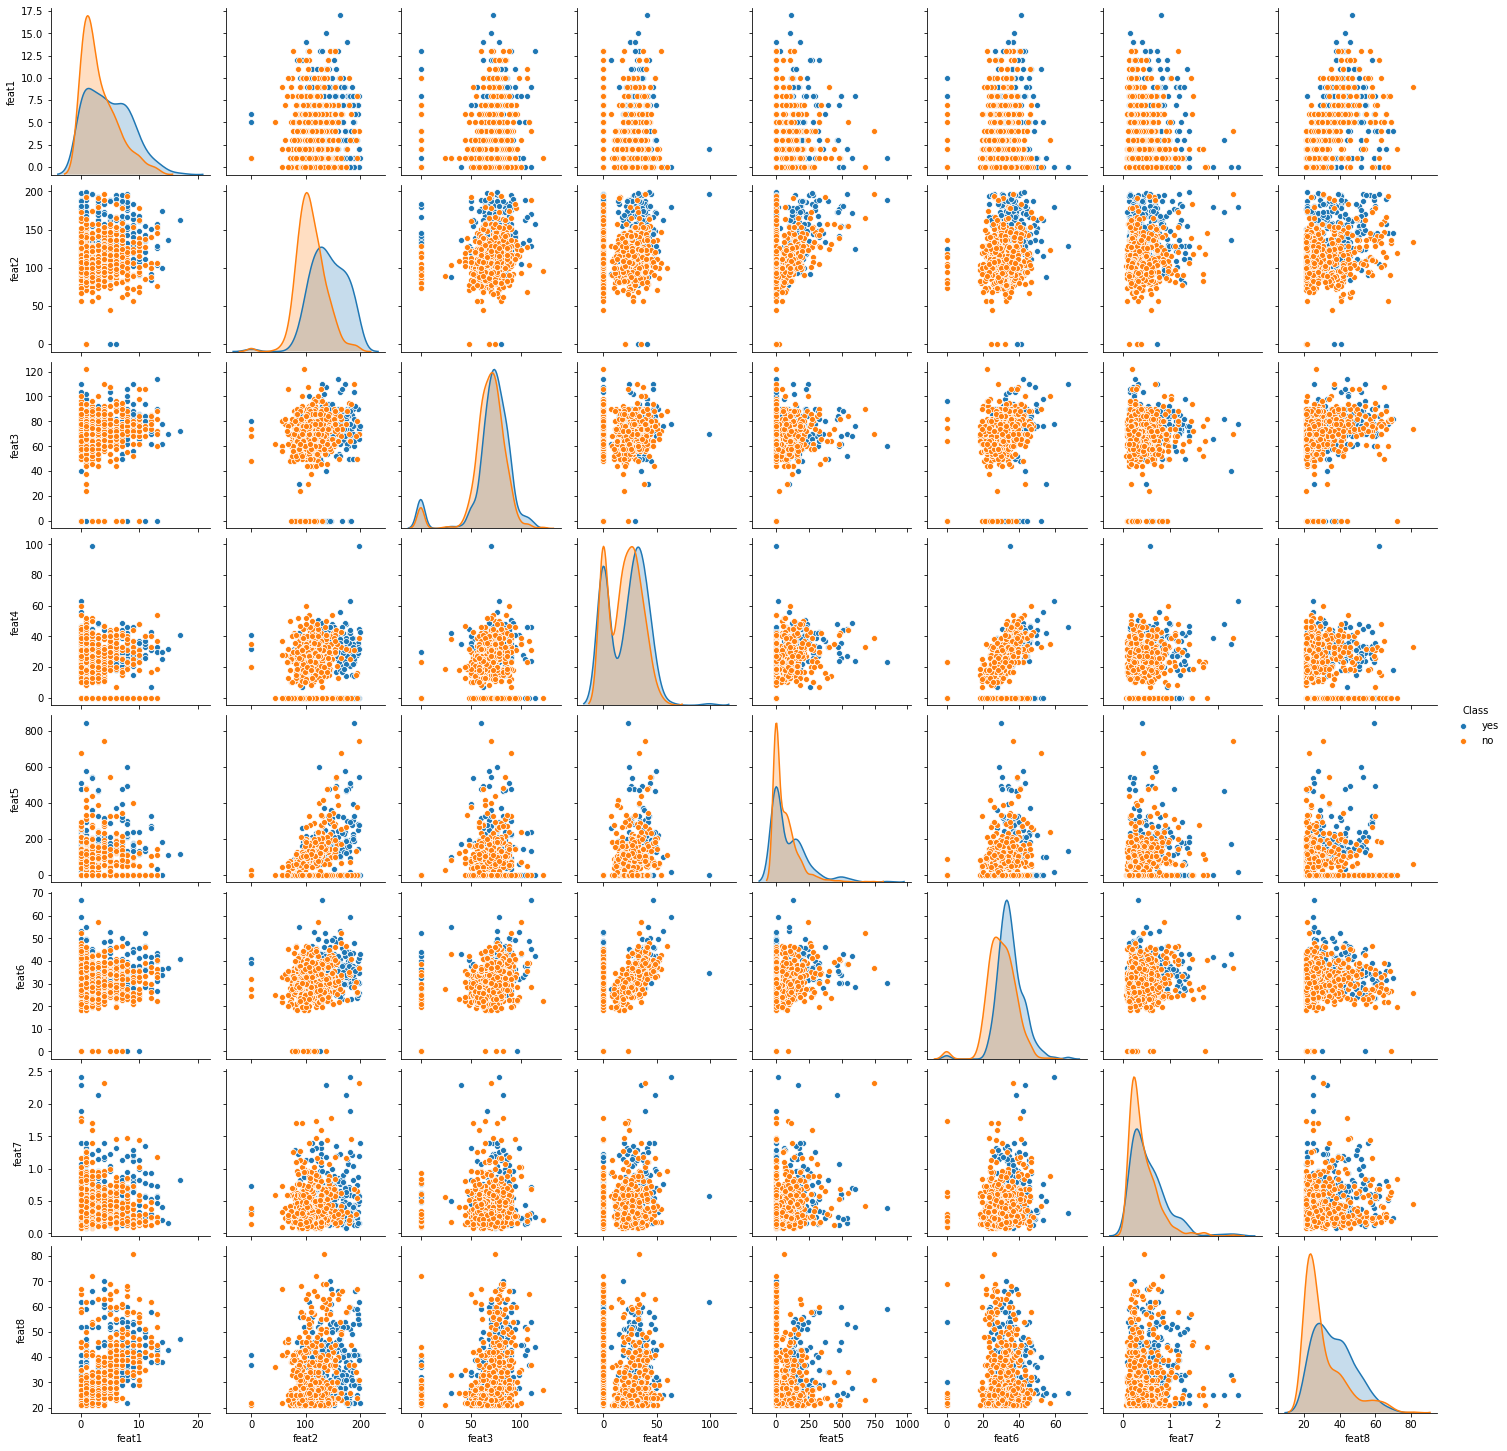

In [6]:
sns.pairplot(data=df,hue='Class',diag_kind = 'kde');

In [7]:
df.describe()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8
count,768.000000,762.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.893701,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885
std,3.369578,32.098411,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000
75%,6.000000,141.000000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000


In [8]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   feat1   768 non-null    int64  
 1   feat2   762 non-null    float64
 2   feat3   768 non-null    int64  
 3   feat4   768 non-null    int64  
 4   feat5   768 non-null    int64  
 5   feat6   768 non-null    float64
 6   feat7   768 non-null    float64
 7   feat8   768 non-null    int64  
 8   Class   768 non-null    object 
dtypes: float64(3), int64(5), object(1)
memory usage: 54.1+ KB


In [9]:
df.corr()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8
feat1,1.000000,0.130169,0.141282,-0.081672,-0.073535,0.017683,-0.033523,0.544341
feat2,0.130169,1.000000,0.152714,0.057471,0.331705,0.221496,0.137762,0.264812
feat3,0.141282,0.152714,1.000000,0.207371,0.088933,0.281805,0.041265,0.239528
feat4,-0.081672,0.057471,0.207371,1.000000,0.436783,0.392573,0.183928,-0.113970
feat5,-0.073535,0.331705,0.088933,0.436783,1.000000,0.197859,0.185071,-0.042163
feat6,0.017683,0.221496,0.281805,0.392573,0.197859,1.000000,0.140647,0.036242
feat7,-0.033523,0.137762,0.041265,0.183928,0.185071,0.140647,1.000000,0.033561
feat8,0.544341,0.264812,0.239528,-0.113970,-0.042163,0.036242,0.033561,1.000000


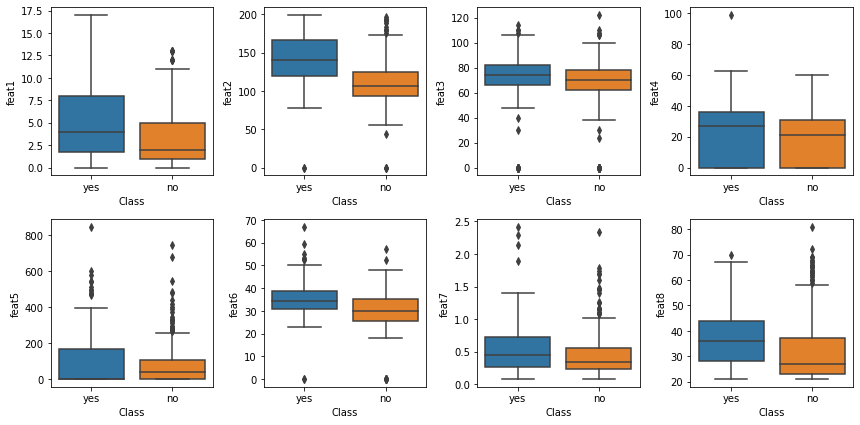

In [10]:
### Use this code to display boxplots.
fig,((ax1,ax2,ax3,ax4),(ax5,ax6,ax7,ax8))=plt.subplots(2,4,figsize = (12,6))
for i,ax in enumerate((ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8)):    
    sns.boxplot(data= df, y=preds[i],x= target,ax=ax)
plt.tight_layout()

#### Data Preprocessing

Use sklearn SimpleImputer to process missing values

In [11]:
np.sum(df.isnull())

feat1    0
feat2    6
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
Class    0
dtype: int64

In [12]:
imp = SimpleImputer()
df.loc[:,'feat2'] =  imp.fit_transform(df.loc[:,'feat2'].values.reshape(-1,1) )
df.tail()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,Class
763,10,101.000000,76,48,180,32.9,0.171,63,no
764,2,122.000000,70,27,0,36.8,0.340,27,no
765,5,120.893701,72,23,112,26.2,0.245,30,no
766,1,126.000000,60,0,0,30.1,0.349,47,yes
767,1,93.000000,70,31,0,30.4,0.315,23,no


#### Check for zeros in the features

Use sklearn SimpleImputer to replace the zeros in features feat4 and feat5 with the means of the feature

In [13]:
for col in df.columns:
    print(f'{col}  {np.sum(df[col] == 0)}')

feat1  111
feat2  5
feat3  35
feat4  227
feat5  374
feat6  11
feat7  0
feat8  0
Class  0


In [14]:
imp_zero = SimpleImputer(missing_values=0,strategy='mean')
df.loc[:,'feat4'] =  imp_zero.fit_transform(df.loc[:,'feat4'].values.reshape(-1,1) )
df.loc[:,'feat5'] =  imp_zero.fit_transform(df.loc[:,'feat5'].values.reshape(-1,1) )

df.tail()

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,Class
763,10,101.000000,76,48.00000,180.000000,32.9,0.171,63,no
764,2,122.000000,70,27.00000,155.548223,36.8,0.340,27,no
765,5,120.893701,72,23.00000,112.000000,26.2,0.245,30,no
766,1,126.000000,60,29.15342,155.548223,30.1,0.349,47,yes
767,1,93.000000,70,31.00000,155.548223,30.4,0.315,23,no


### Generic Model & Results

In [15]:
def run_model(model,X,y):
    '''
    Inputs:
    model: a sklearn machine learning object
    X: numpy array of features
    y: numpy vector of target variable
    
    Returns:
    model: fitted model
    X_test: test data for feature
    y_test: test data for target'''
    
    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.25) 
                                                       
    # Scaling
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

    # Model
   
    print(model)

    # Fit the training data
    model.fit(X_train, y_train)
    
    # Predict the test data
    yhat = model.predict(X_test)

    # Calculate the accuracy, error,precision,recall and f1
    cm = confusion_matrix(y_test, yhat)
    
    tp,fp,fn,tn = cm[1,1],cm[0,1],cm[1,0],cm[0,0]
    
    accuracy = np.trace(cm)/np.sum(cm)
    error = 1 - accuracy
    precision = tp/(tp+fp)
    recall = tp/(tp+fn) 
    f1 = tp/(tp + 1/2*(fp+fn))
    print("Confusion Matrix:")
    print(cm)
    print(f'Accuracy: {accuracy}\nError: {error}')
    print(f'Precision: {precision}\nRecall: {recall}\nF1: {f1}')
   
    return model,X_test,y_test

#### Display ROC, Auc and Decision Boundary

In [16]:
def classification_plots (model,X_data,y_data):
    # Calculate class probabilities for each data point
    y_pred_probs = model.predict_proba(X_data) 
    # Calculate false positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(y_data, y_pred_probs[:,1]) 
    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    #### Plot ROC curves 

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate');

#### Decision Boundary plot

    plot_decision_boundary(model,X_data,y_data)

 
### K-nearest Neighbor  Model

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

* Classification algorithm
    - Classify a point according to the the class of its K closest neighbors
* Regression algorithm
    - Assign y value to the mean of the K closest neighbors
* Closest determined by some distance measure
* Simple algorithm but often gives very good results
* Lazy learner: just uses the training data, doesn't really learn anything    
* How to choose the hyperparameter K?


### KNN Algorithm

1. Choose K (the number of neighbors to use)
2. Find the K nearest neighbors to the new point $x_{new}$ using a distance measure (most common is Euclidean Distance)  

<div style="font-size: 110%;">
    $$\text{Euclidean distance between two points }(x_1,y_1),(x_2,y_2) = \sqrt{(x_1 - x_2)^2 + (y_1 - y_2)^2}$$
</div>
 
3. Among these K neighbors count the number in each category (i.e. class)
4. Assign the new point the category  with the highest count


* The algorithm estimates the conditional probability for class j as the fraction of points in $N_{new}$ with response value j and classifies $X_{new}$ to the class with highest probability.

$$Pr(Y=j|X=x_{new}) = \frac{1}{K}\sum_{i\in{N_{new}}}I(y_i=j)$$

### Distance Measures

 http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html




### KNN Model

Function to run KNN model with 1 hyperparameter, the number of nearest neighbors.  

Inputs: Features, target, list of hyperparameters

Returns the average score over the number of iterations, the model, the X test data and the y test data.

In [17]:
def run_knn(X,y,hyperparams,iter=5):
    avg_scores = np.zeros(len(hyperparams))
    for j in range(len(hyperparams)):
        N = hyperparams[j]
        scores = 0
        print('N: ',N)
        for i in range(iter):
            model = KNeighborsClassifier(n_neighbors = N, 
                                         metric = 'euclidean') 
            model,X_test,y_test = run_model(model,X,y)
            scores += model.score(X_test,y_test)
        avg_scores[j] = scores/iter
    return avg_scores,model,X_test,y_test
        

#### Run KNN model with all the features

Features: All  
Hyperparameters: (1,5,10)  
Number of iterations for each hyperparameter: 5

In [18]:
feats = preds
X = df.loc[:, feats].values
y =  LabelEncoder().fit_transform(df.Class)
avg_scores,model,X_test,y_test = run_knn(X,y,(1,5,10))


N:  1
(576, 8) (192, 8) (576,) (192,)
KNeighborsClassifier(metric='euclidean', n_neighbors=1)
Confusion Matrix:
[[100  25]
 [ 30  37]]
Accuracy: 0.7135416666666666
Error: 0.28645833333333337
Precision: 0.5967741935483871
Recall: 0.5522388059701493
F1: 0.5736434108527132
(576, 8) (192, 8) (576,) (192,)
KNeighborsClassifier(metric='euclidean', n_neighbors=1)
Confusion Matrix:
[[93 32]
 [29 38]]
Accuracy: 0.6822916666666666
Error: 0.31770833333333337
Precision: 0.5428571428571428
Recall: 0.5671641791044776
F1: 0.5547445255474452
(576, 8) (192, 8) (576,) (192,)
KNeighborsClassifier(metric='euclidean', n_neighbors=1)
Confusion Matrix:
[[97 28]
 [28 39]]
Accuracy: 0.7083333333333334
Error: 0.29166666666666663
Precision: 0.582089552238806
Recall: 0.582089552238806
F1: 0.582089552238806
(576, 8) (192, 8) (576,) (192,)
KNeighborsClassifier(metric='euclidean', n_neighbors=1)
Confusion Matrix:
[[98 27]
 [27 40]]
Accuracy: 0.71875
Error: 0.28125
Precision: 0.5970149253731343
Recall: 0.597014925373

In [19]:
print(f'Average scores per hyperparameter: {avg_scores}')

Average scores per hyperparameter: [0.703125   0.73958333 0.75      ]


#### Run KNN model with two features

Features: Two features you think will give the best prediction  
Hyperparameters: (5,10)  
Number of iterations: 5

In [20]:
feats = ['feat2','feat8']
X = df.loc[:, feats].values
y =  LabelEncoder().fit_transform(df.Class)
avg_scores,model,X_test,y_test = run_knn(X,y,(5,10))

N:  5
(576, 2) (192, 2) (576,) (192,)
KNeighborsClassifier(metric='euclidean')
Confusion Matrix:
[[99 26]
 [26 41]]
Accuracy: 0.7291666666666666
Error: 0.27083333333333337
Precision: 0.6119402985074627
Recall: 0.6119402985074627
F1: 0.6119402985074627
(576, 2) (192, 2) (576,) (192,)
KNeighborsClassifier(metric='euclidean')
Confusion Matrix:
[[108  17]
 [ 28  39]]
Accuracy: 0.765625
Error: 0.234375
Precision: 0.6964285714285714
Recall: 0.582089552238806
F1: 0.6341463414634146
(576, 2) (192, 2) (576,) (192,)
KNeighborsClassifier(metric='euclidean')
Confusion Matrix:
[[104  21]
 [ 37  30]]
Accuracy: 0.6979166666666666
Error: 0.30208333333333337
Precision: 0.5882352941176471
Recall: 0.44776119402985076
F1: 0.5084745762711864
(576, 2) (192, 2) (576,) (192,)
KNeighborsClassifier(metric='euclidean')
Confusion Matrix:
[[104  21]
 [ 28  39]]
Accuracy: 0.7447916666666666
Error: 0.25520833333333337
Precision: 0.65
Recall: 0.582089552238806
F1: 0.6141732283464567
(576, 2) (192, 2) (576,) (192,)
KN

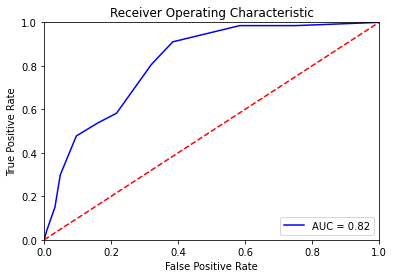

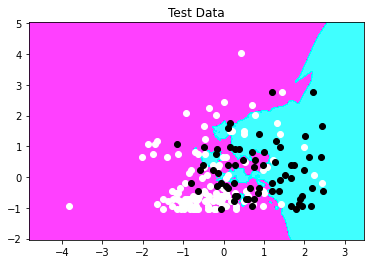

In [21]:
classification_plots(model,X_test,y_test)

### Logisitic Regression Model

Function to run Logistic Regression model with no hyperparameters

Inputs: Features, target

Returns the average score over the number of iterations, the model, the X test data and the y test data.



In [22]:
def run_log_regress(X,y,iter=5):
    scores = 0
    for i in range(iter):
        model = LogisticRegression() 
        model,X_test,y_test = run_model(model,X,y)
        scores += model.score(X_test,y_test)
    print(f'Average score: {scores}')
    return model,X_test,y_test

#### Run Logistic Regresssion model with all the features

No hyperparameters  
Number of iterations: 5

In [23]:
feats = preds
X = df.loc[:, feats].values
y =  LabelEncoder().fit_transform(df.Class)
model,X_test,Y_test = run_log_regress(X,y)

(576, 8) (192, 8) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[118   7]
 [ 36  31]]
Accuracy: 0.7760416666666666
Error: 0.22395833333333337
Precision: 0.8157894736842105
Recall: 0.4626865671641791
F1: 0.5904761904761905
(576, 8) (192, 8) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[112  13]
 [ 34  33]]
Accuracy: 0.7552083333333334
Error: 0.24479166666666663
Precision: 0.717391304347826
Recall: 0.4925373134328358
F1: 0.584070796460177
(576, 8) (192, 8) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[112  13]
 [ 37  30]]
Accuracy: 0.7395833333333334
Error: 0.26041666666666663
Precision: 0.6976744186046512
Recall: 0.44776119402985076
F1: 0.5454545454545454
(576, 8) (192, 8) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[110  15]
 [ 32  35]]
Accuracy: 0.7552083333333334
Error: 0.24479166666666663
Precision: 0.7
Recall: 0.5223880597014925
F1: 0.5982905982905983
(576, 8) (192, 8) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[110  15]
 [ 28  39]]
Ac

#### Run Logistic Regresssion model with two features

Features: Two features you think will give the best prediction 
Number of iterations: 5

(576, 2) (192, 2) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[114  11]
 [ 37  30]]
Accuracy: 0.75
Error: 0.25
Precision: 0.7317073170731707
Recall: 0.44776119402985076
F1: 0.5555555555555556
(576, 2) (192, 2) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[106  19]
 [ 32  35]]
Accuracy: 0.734375
Error: 0.265625
Precision: 0.6481481481481481
Recall: 0.5223880597014925
F1: 0.5785123966942148
(576, 2) (192, 2) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[114  11]
 [ 34  33]]
Accuracy: 0.765625
Error: 0.234375
Precision: 0.75
Recall: 0.4925373134328358
F1: 0.5945945945945946
(576, 2) (192, 2) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[109  16]
 [ 35  32]]
Accuracy: 0.734375
Error: 0.265625
Precision: 0.6666666666666666
Recall: 0.47761194029850745
F1: 0.5565217391304348
(576, 2) (192, 2) (576,) (192,)
LogisticRegression()
Confusion Matrix:
[[115  10]
 [ 33  34]]
Accuracy: 0.7760416666666666
Error: 0.22395833333333337
Precision: 0.7727272727272727
Reca

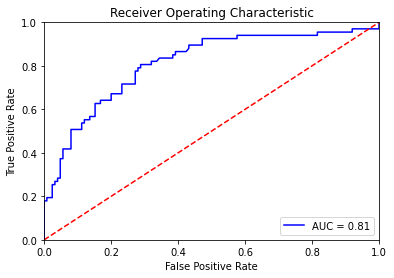

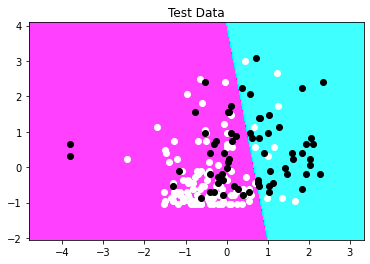

In [24]:
feats = ['feat2','feat8']
X = df.loc[:, feats].values
y =  LabelEncoder().fit_transform(df.Class)
model,X_test,y_test = run_log_regress(X,y)
classification_plots(model,X_test,y_test)

### Support Vector Machine model

Function to run SVM model with 2 hyperparameters, C and the kernel

Inputs: Features, target, list of hyperparameters

Returns the average score over the number of iterations, the model, the X test data and the y test data.

In [25]:
def run_svm(X,y,hyperparams,iter=5):
    avg_scores = np.zeros(len(hyperparams))
    for j in range(len(hyperparams)):
        C = hyperparams[j][0]
        K = hyperparams[j][1]
        scores = 0
        print('C: ',C,' K:',K)
        for i in range(iter):
            model = SVC(C = C, kernel = K,probability = True)
            model,X_test,y_test = run_model(model,X,y)
            scores += model.score(X_test,y_test)
        avg_scores[j] = scores/iter
   
    return avg_scores,model,X_test,y_test

#### Run Logistic Regresssion model with all features

Features: All  
Hyperparameters: List of lists: ((C,kernel),(C,kernel),...)  
(1.0,'linear'),(1.0,'rbf'),(1.0,'poly')  
Number of iterations: 5

In [26]:
feats = df.columns[0:-1]
X = df.loc[:, feats].values
y =  LabelEncoder().fit_transform(df.Class)
hyper = ((1.0,'linear'),(1.0,'rbf'),(1.0,'poly'))
avg_scores,model,X_test,y_test = run_svm(X,y,hyper)

C:  1.0  K: linear
(576, 8) (192, 8) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[113  12]
 [ 33  34]]
Accuracy: 0.765625
Error: 0.234375
Precision: 0.7391304347826086
Recall: 0.5074626865671642
F1: 0.6017699115044248
(576, 8) (192, 8) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[112  13]
 [ 29  38]]
Accuracy: 0.78125
Error: 0.21875
Precision: 0.7450980392156863
Recall: 0.5671641791044776
F1: 0.6440677966101694
(576, 8) (192, 8) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[113  12]
 [ 32  35]]
Accuracy: 0.7708333333333334
Error: 0.22916666666666663
Precision: 0.7446808510638298
Recall: 0.5223880597014925
F1: 0.6140350877192983
(576, 8) (192, 8) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[109  16]
 [ 26  41]]
Accuracy: 0.78125
Error: 0.21875
Precision: 0.7192982456140351
Recall: 0.6119402985074627
F1: 0.6612903225806451
(576, 8) (192, 8) (576,) (192,)
SVC(kernel='linear', pro

In [27]:
print(f'Average Scores: {avg_scores}')

Average Scores: [0.76666667 0.759375   0.72083333]


#### Run SVM model with wo features

Features: Two features you think will give the best prediction   
Hyperparameters: List of lists: ((C,kernel),(C,kernel),...)  
(1.0,'linear'),(1.0,'rbf'),(1.0,'poly')  
Number of iterations: 5

In [28]:
feats = ['feat2','feat8']
X = df.loc[:, feats].values
y =  LabelEncoder().fit_transform(df.Class)
hyper = ((1.0,'linear'),(1.0,'rbf'),(1.0,'poly'))
avg_scores,model,X_test,Y_test = run_svm(X,y,hyper)

C:  1.0  K: linear
(576, 2) (192, 2) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[109  16]
 [ 29  38]]
Accuracy: 0.765625
Error: 0.234375
Precision: 0.7037037037037037
Recall: 0.5671641791044776
F1: 0.628099173553719
(576, 2) (192, 2) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[107  18]
 [ 30  37]]
Accuracy: 0.75
Error: 0.25
Precision: 0.6727272727272727
Recall: 0.5522388059701493
F1: 0.6065573770491803
(576, 2) (192, 2) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[110  15]
 [ 32  35]]
Accuracy: 0.7552083333333334
Error: 0.24479166666666663
Precision: 0.7
Recall: 0.5223880597014925
F1: 0.5982905982905983
(576, 2) (192, 2) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Matrix:
[[111  14]
 [ 34  33]]
Accuracy: 0.75
Error: 0.25
Precision: 0.7021276595744681
Recall: 0.4925373134328358
F1: 0.5789473684210527
(576, 2) (192, 2) (576,) (192,)
SVC(kernel='linear', probability=True)
Confusion Mat

Average Scores: [0.740625   0.75833333 0.70208333]


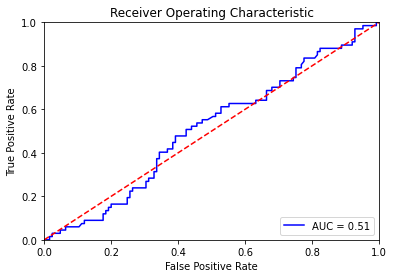

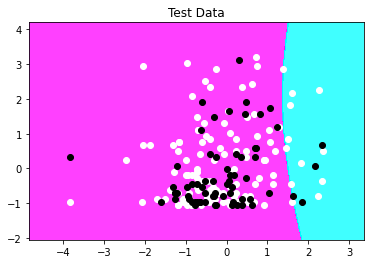

In [29]:
print(f'Average Scores: {avg_scores}')
classification_plots(model,X_test,y_test)

### Part 2:  PyTorch SVM model for the dataset with all the features

You only have to convert your training data to PyTorch tensors
and define your model class with 2 linear layers, named linear1 and linear2.  
Apply a ReLU function to linear1 and send the output to linear2.  
Linear2 should have 8 nodes.  
Use the Adam optimizer with a learning rate of 0.01

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
torch.__version__

'1.5.0'

In [48]:
feats = preds
X = df.loc[:, feats].values
y = LabelEncoder().fit_transform(df.Class)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.30, 
                                                    )
# Scaling
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Convert data into torch tensors
X_train_t = torch.from_numpy(X_train.astype(np.float32))
X_test_t = torch.from_numpy(X_test.astype(np.float32))
y_train_t = torch.from_numpy(y_train.astype(np.float32).reshape(-1, 1))
y_test_t = torch.from_numpy(y_test.astype(np.float32).reshape(-1, 1))


X_train_t.shape,X_test_t.shape,y_train_t.shape,y_test_t.shape 

(torch.Size([537, 8]),
 torch.Size([231, 8]),
 torch.Size([537, 1]),
 torch.Size([231, 1]))

In [49]:
X_train[0:5,:]

array([[0.35294118, 0.62311558, 0.63157895, 0.24079804, 0.17013008,
        0.41132638, 0.12382579, 0.13333333],
       [0.05882353, 0.71859296, 0.73684211, 0.17391304, 0.35576923,
        0.6318927 , 0.42613151, 0.01666667],
       [0.52941176, 0.7839196 , 0.75438596, 0.24079804, 0.17013008,
        0.36959762, 0.06490179, 0.53333333],
       [0.23529412, 0.56281407, 0.68421053, 0.35869565, 0.17013008,
        0.58718331, 0.06746371, 0.28333333],
       [0.29411765, 0.53266332, 0.71929825, 0.25      , 0.17013008,
        0.58867362, 0.08881298, 0.28333333]])

#### Class definition

Define a network with all the features as inputs.

In [43]:
class SVM(nn.Module):
    def __init__(self,num_in,num_out):
        super(SVM,self).__init__()
        self.linear1=nn.Linear(num_in,8)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(8,num_out)
        
    def forward(self,x):
        z = self.relu(self.linear1(x))
        z = self.linear2(z)
        return z
    
model = SVM(8,1)    


In [44]:
lr = 0.01
optimizer = optim.Adam(model.parameters(),lr=lr)

def svm_loss(w,y,lin_out,c):
    constraint = torch.mean(torch.clamp(1 - y * lin_out, min=0)) #>= 0
    return c*torch.dot(w.t(),w)/2.0 + constraint

In [45]:
def train(X, Y, model, batchsize,epochs,c):
    N = len(Y)
    model.train()
    for epoch in range(epochs):
        perm = torch.randperm(N)
        sum_loss = 0

        for i in range(0, N, batchsize):
            x = X[perm[i : i + batchsize]]
            y = Y[perm[i : i + batchsize]]

            optimizer.zero_grad()
            output = model(x).squeeze()
            weight = model.linear2.weight.squeeze()
            loss = svm_loss(weight,y,output,c)
            loss.backward()
            optimizer.step()

            sum_loss += float(loss)
    print(sum_loss/N)

In [46]:
def torch_accuracy():
    with torch.no_grad():
      p_train = model(X_train_t)  ## Predict
      p_train = np.round(p_train.cpu().numpy())
      train_acc = np.mean(y_train_t.cpu().numpy() == p_train) # Get accuracy

      p_test = model(X_test_t) ## Predict
      p_test = np.round(p_test.cpu().numpy())
      test_acc = np.mean(y_test_t.cpu().numpy() == p_test) # Get accuracy
    print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

In [47]:
c = 100.0
batchsize = 50
num_epochs = 500
for i in range(5):
    train(X_train_t, y_train_t, model, batchsize, num_epochs, c)
    torch_accuracy()

0.013349438901276118
Train acc: 0.3482, Test acc: 0.3506
0.01336253033447976
Train acc: 0.3482, Test acc: 0.3506
0.013244757883153593
Train acc: 0.3482, Test acc: 0.3506
0.013350237126234968
Train acc: 0.3482, Test acc: 0.3506
0.013401858522461335
Train acc: 0.3482, Test acc: 0.3506


## Linear Algebra

For the marix A below, calculate ATA the square matrix of A times A transpose.
Show that the singular values of the Singular Value Decomposition of A are equal to the square root of the eigenvalues of ATA.

In [37]:
A = np.array([[1,2,3,4],[5,6,7,8]])

ATA = A.dot(A.T)

e,v = la.eig(ATA)
S = la.svd(A)
print(e,S[1],np.sqrt(e))

[  1.58087831 202.41912169] [14.22740741  1.25732984] [ 1.25732984 14.22740741]



Given x and z below. Define a function Poly_k that implements the polynomial kernel with r = 0 and d = 2. Also define a function Phi that computes the dot product of the $\phi$ transformation. Show that given the inputs x and z they compute the same value.
$\Phi(\vec{x}) = (x_1^2,\sqrt{2}x_1x_2,x_2^2) $

In [38]:
x = np.array([3,4])
z = np.array([2,5])

In [39]:

def poly_K(x,z,r = 0,d = 2):
    return (np.dot(x,z) + r)**d

def Phi(x):
    return np.array([x[0]**2, np.sqrt(2)*x[0]*x[1], x[1]**2])

print(poly_K(x,z),np.dot(Phi(x),Phi(z)))

676 676.0
